# Looking for another place to increase the Gold's Gym

## Explane the problem

The Gold's Gym is, maybe, the most famous gyms network in the world, where many actors and famous people use to workout. More especially, the unity located in Los Angeles (735 S Figueroa St Ste 100, Los Angeles, CA 90017, Estados Unidos), where is very crowded because it has many users using the same place at the same time. For spread and don't lose your clients, the owner had one idea: "I want to open a new gym around 500 meters the old gym!". But he knows in this neighborhood have a lot of competitors with other gyms, to decrease the change to lose clients the owner wants to know how he can open the new gym station in a location with fewer concurrents.

That information is really important for the owner of the gold's gym because he can improve the high investment, he'd use to expand the gym.

## What's the dataset we need to solve this problem?

To solve this problem, we need to get through the Foursquare API the location of another gym around the Gold's Gym and for cluster those gyms we'll use the K-Means algorithm.

To determine the cardinal point is better to implant a new gym, we'll use the initial point to K-Means algorithm, which in that turn tends to return the cluster with the other gyms surrounding the Gold's Gym. The region with less concurrence could be the best place to create a new establishment.

For example, with the new gym has been opened in a place surrounded by other gyms, investors would lose their money with this business.

## Example of the data would be use for solve this problem

### Importing Library

In [1]:
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation

from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

import folium # plotting library

from sklearn.cluster import KMeans #KMeans library
from sklearn.preprocessing import scale

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

### Importing the Foursquare API

In [2]:
CLIENT_ID = '3JTWJGZF0FAEOFU2K5US1I4O1QG3U2YLRANJHSL33PW4RCPS' # your Foursquare ID
CLIENT_SECRET = '1LIVDOD2UKLHWHVYREMVJ1TBYAIFXYX1DNVZFCCKF3TY25G4' # your Foursquare Secret
VERSION = '20180604' # version of foursquare api
LIMIT = 500 #limit of output

In [3]:
# Latitude and longitude of Gold's Gym
latitude = '34.048660'
longitude = '	-118.260450'
# Query for input on foursquare
search_query = 'Gym'
#Radius of search on map
radius =800
# URL 
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, radius, LIMIT)
url

'https://api.foursquare.com/v2/venues/search?client_id=3JTWJGZF0FAEOFU2K5US1I4O1QG3U2YLRANJHSL33PW4RCPS&client_secret=1LIVDOD2UKLHWHVYREMVJ1TBYAIFXYX1DNVZFCCKF3TY25G4&ll=34.048660,\t-118.260450&v=20180604&query=Gym&radius=800&limit=500'

In [4]:
results = requests.get(url).json() #Json generated in foursquare api
results

{'meta': {'code': 200, 'requestId': '5efe1833587699312d468f73'},
 'response': {'venues': [{'id': '4b12d08ef964a520a78e23e3',
    'name': "Gold's Gym",
    'location': {'address': '735 S Figueroa St Ste 100',
     'crossStreet': 'at 7th St.',
     'lat': 34.04866,
     'lng': -118.26045,
     'labeledLatLngs': [{'label': 'display',
       'lat': 34.04866,
       'lng': -118.26045}],
     'distance': 0,
     'postalCode': '90017',
     'cc': 'US',
     'city': 'Los Angeles',
     'state': 'CA',
     'country': 'United States',
     'formattedAddress': ['735 S Figueroa St Ste 100 (at 7th St.)',
      'Los Angeles, CA 90017',
      'United States']},
    'categories': [{'id': '4bf58dd8d48988d176941735',
      'name': 'Gym',
      'pluralName': 'Gyms',
      'shortName': 'Gym',
      'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/building/gym_',
       'suffix': '.png'},
      'primary': True}],
    'venuePage': {'id': '554208029'},
    'referralId': 'v-1593710594',
    'hasPerk

### Data mining

In [5]:
# assign relevant part of JSON to venues
gyms = results['response']['venues']

# tranform json into a dataframe
df = json_normalize(gyms)
# drop the first row, because this is the Gold's Gym location
df = df.drop(0, axis = 0)
#reset index the in
df.reset_index(drop = True, inplace = True)
# show the shape of the dataframe 
df.shape

C:\Users\lucas\anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  """


(49, 18)

In [6]:
# keep only columns that include venue name, and anything that is associated with location
filtered_columns = ['name', 'categories'] + [col for col in df.columns if col.startswith('location.')] + ['id']
dataframe_filtered = df.loc[:, filtered_columns]

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# filter the category for each row
dataframe_filtered['categories'] = dataframe_filtered.apply(get_category_type, axis=1)

# clean column names by keeping only last term
dataframe_filtered.columns = [column.split('.')[-1] for column in dataframe_filtered.columns]

dataframe_filtered.shape

(49, 15)

### Printing the Map

In [7]:
gym_map = folium.Map(location=[latitude, longitude], zoom_start=15) # generate map centred around the Gold's Gym

# add a red circle marker to represent the Gold's Gym
folium.Marker(
    [latitude, longitude],
    radius=10,
    color='red',
    popup="Gold's Gym",
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.6
    ).add_to(gym_map)

# add the Italian restaurants as blue circle markers
for lat, lng, label in zip(dataframe_filtered.lat, dataframe_filtered.lng, dataframe_filtered.name):
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        popup=label,
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(gym_map)

# display map
gym_map

### Clustering the locations

In [8]:
# filtring dataframe for best localization in map
x = dataframe_filtered[['lat', 'lng']]
# seting the start point for KMeans methods, because this represents cardinal points
start_point = np.array([[34.06079,-118.264444],[34.031588,-118.260010],[34.049686,-118.284829],[34.048864,-118.237971]])

In [9]:
# scaling the data
data = scale(x)
# start_point = scale(start_point)
neigh = KMeans(n_clusters = 4, init = start_point, max_iter = 500)
#fit the model
neigh.fit(x)

C:\Users\lucas\anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  


KMeans(algorithm='auto', copy_x=True,
       init=array([[  34.06079 , -118.264444],
       [  34.031588, -118.26001 ],
       [  34.049686, -118.284829],
       [  34.048864, -118.237971]]),
       max_iter=500, n_clusters=4, n_init=10, n_jobs=None,
       precompute_distances='auto', random_state=None, tol=0.0001, verbose=0)

In [10]:
# insert the cluster labels into data frame
dataframe_filtered.insert(0, 'Cluster Labels', neigh.labels_)

In [11]:
# print the head of dataframe
dataframe_filtered.head()

,Cluster Labels,name,categories,address,crossStreet,lat,lng,labeledLatLngs,distance,postalCode,cc,city,state,country,formattedAddress,id
0,3,"The Gym at The Standard, Downtown LA",Gym,550 S Flower St,6th Street,34.050159,-118.256973,"[{'label': 'display', 'lat': 34.0501594543457,...",361,90071,US,Los Angeles,CA,United States,"[550 S Flower St (6th Street), Los Angeles, CA...",4c12716877cea593810bcd60
1,0,1100 Wilshire Gym,Gym,1100 Wilshire Blvd,Bixel,34.052421,-118.263674,"[{'label': 'display', 'lat': 34.05242144083761...",513,90017,US,Los Angeles,CA,United States,"[1100 Wilshire Blvd (Bixel), Los Angeles, CA 9...",4ca3b9661ee76dcb4ba8fbdd
2,3,Pegasus Rooftop Gym,Gym,612 S Flower St,btw 6th & Wilshire,34.049879,-118.257211,"[{'label': 'display', 'lat': 34.04987890803485...",328,90017,US,Los Angeles,CA,United States,"[612 S Flower St (btw 6th & Wilshire), Los Ang...",4c6ebc6910faa1431899f168
3,0,Piero Gym,Gym,616 St Paul Ave,at Wilshire Blvd,34.052731,-118.260895,"[{'label': 'display', 'lat': 34.05273056030273...",454,90017,US,Los Angeles,CA,United States,"[616 St Paul Ave (at Wilshire Blvd), Los Angel...",4bcf67bf046076b0023e6e71
4,1,717 8th Floor Gym,Gym,717 W Olympic Blvd,Figueroa,34.045090,-118.263321,"[{'label': 'display', 'lat': 34.04508972167969...",477,90015,US,Los Angeles,CA,United States,"[717 W Olympic Blvd (Figueroa), Los Angeles, C...",4d55f1e258856dcbd7f2506d


### Printing the map with clusters

In [12]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=15)

# set color scheme for the clusters
x = np.arange(4)
ys = [i + x + (i*x)**2 for i in range(4)]
colors_array = ['green','red','darkblue','black']
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(dataframe_filtered['lat'], dataframe_filtered['lng'], dataframe_filtered['name'], dataframe_filtered['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
# add the gold's gym's marks   
folium.Marker(
    [latitude, longitude],
    radius=10,
    color='red',
    popup="Gold's Gym",
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.6
    ).add_to(map_clusters)
# print the map      
map_clusters

### Quantity of gyms in each clusters

In [24]:
#selecting relevants values
result = dataframe_filtered[['Cluster Labels', 'name']]

In [25]:
#showing the quantity of gym in each cluster
result_group = result.groupby(by = 'Cluster Labels', axis = 0).count()
# change index
result_group.reset_index(inplace = True)
# change colums name
result_group.columns = ['Cluster Labels', 'Number of gyms']

In [26]:
#replace the clusters numbers
for i, j in enumerate(result_group['Cluster Labels']):
    if j == 0:
        result_group['Cluster Labels'][i] = 'West'
    elif j == 1:
        result_group['Cluster Labels'][i] = 'South'
    elif j == 2:
        result_group['Cluster Labels'][i] = 'East'
    elif j == 3:
        result_group['Cluster Labels'][i] = 'North'

C:\Users\lucas\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\lucas\anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\lucas\anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [101]:

result_group

,Cluster Labels,Number of gyms
0,West,10
1,South,13
2,East,11
3,North,15


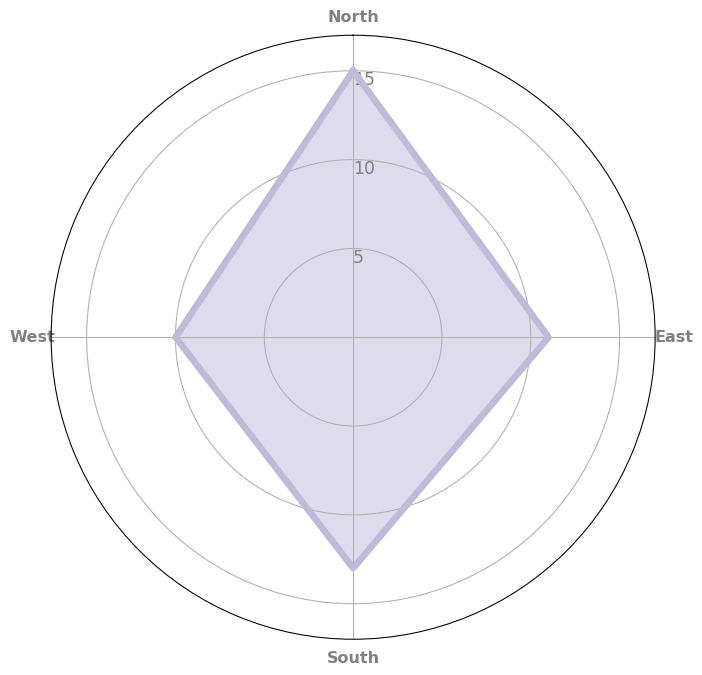

In [204]:
# ------- PART 1: Define a function that do a plot for one line of the dataset!
 
def make_spider(title, color):
 
    #number of variable
    categories=list(result_group['Cluster Labels'])
    categories.reverse()
    N = len(categories)

    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [(n / float(N) * 2 * pi) for n in range(N)]
#    angles.reverse()
    angles += angles[:1]


    # Initialise the spider plot
    ax = plt.subplot(111, polar=True)

    # If you want the first axis to be on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    # Draw one axe per variable + add labels labels yet
    plt.xticks(angles[:-1], categories, color='grey', size= 12, fontweight = 'bold')

    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks([5,10,15], ["5","10","15"], color="grey", size=13, verticalalignment = 'top', y = 0.8)
    plt.ylim(0,17)

    # Ind1
    values=result_group['Number of gyms'].tolist()
    values.reverse()
    values += values[:1]
    
    ax.plot(angles, values, color= color, linewidth=5, linestyle='solid')
    ax.fill(angles, values, color=color , alpha=0.5)

#     # Add a title
#     plt.title(title, size=30, color=color, y=1.1)

#Part 2 Apply to all individuals
# initialize the figure
my_dpi=96
plt.figure(figsize=(800/my_dpi, 800/my_dpi), dpi=my_dpi)
 
# Create a color palette:
my_palette = plt.cm.get_cmap("Set3", 10)

make_spider(title= 'Gyms around', color = my_palette(2))
plt.savefig('radar.png', transparent= True)